In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch import Tensor
from torch.nn import Linear, Module, Parameter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from einops import rearrange
import timm
import matplotlib.pyplot as plt
from keras.preprocessing import image
import csv
import math
import pandas as pd
import skrf as rf
from typing import List, Tuple
import time

/home/ch106/miniconda3/envs/jupyter/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-08-25 15:47:47.508422: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756154867.535848  761659 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756154867.545226  761659 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-25 15:47:47.577548: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-c

In [2]:
fmax = 200
fstart = 0 
#data loading function for images and tabular- derived from CNN path, same function used for MLP
#define function for loading images and s-parameters
#"path" is the path for images of transformer layout
#"label" is the path for labels. In this case, labels are S-parameter associated with each images 
def load_images_from_path(path, label,length):
    images = []
    labels = []
    error = []
    for kk in range(length):
        #load images
        img = image.load_img(path+str(kk)+'.png', target_size=(300, 300, 3))
        images.append(image.img_to_array(img)[38:262,38:262,:])#trim the ground margin

        #load S-parameters
        #According to symmerty, only S11,S12,S13,S14,S33,S34 are considered
        #Each S-parameter has real and imaginary parts, and hence 12 real values in total.
        results = []
        datafile = label+str(kk)+".s4p"
        spt = rf.Network(datafile)
        step = int(1e9/(spt.f[1]-spt.f[0]))
        for k in range(fmax+1):
            i = int((k+fstart)*step/2)
            results.append([spt.s[i][0][0].real,spt.s[i][0][0].imag,
                            spt.s[i][0][1].real,spt.s[i][0][1].imag,
                            spt.s[i][0][2].real,spt.s[i][0][2].imag,
                            spt.s[i][0][3].real,spt.s[i][0][3].imag,
                            spt.s[i][2][2].real,spt.s[i][2][2].imag,
                            spt.s[i][2][3].real,spt.s[i][2][3].imag])     
        labels.append(results)
        sp = np.array(results)
        invalid = False
        '''
        for k in range(len(sp)-3):
            for x in range(6):
                if (np.square(sp[k][2*x])+np.square(sp[k][2*x+1]))>1.02:
                    invalid = True
                
            for x in range(12):
                if abs(sp[k][x]+sp[k+2][x]-2*sp[k+1][x])>0.03:
                    invalid = True
                    '''
        if (invalid):
            error.append(kk)
    return images, labels,error

def show_images(images):
    fig, axes = plt.subplots(1, 8, figsize=(20, 20), subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i] / 255)

In [3]:
def load_from_path_MxN(path):
    logfile = open(path+"log.txt","r")
    listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
    tabular_data = np.array(listall)

#load images and s-parameters
    length = len(tabular_data)
    images, labels,error = load_images_from_path(path+"PNG/", path+"SPData/",length)

    show_images(images)
    srf = np.load(path+"/srf.npy")

    for kk in range(length):
    #select 1 turn and 1 turn transformers
        if kk in error:
            continue   
        if((tabular_data[kk,4]!=0) and (tabular_data[kk,5]!=0)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
            temp = next((item for item in reversed(tabular_data) if item[19] == kk), None)
            geoparas.append(np.array(temp)[[0,1,2,3,4,5,6,7,8,9,10,11,14,15,16,17]])
            images11.append(images[kk])
            labels11.append(labels[kk])
            srf_list.append(srf[kk])

In [4]:
def load_from_path_parallel(path):
    logfile = open(path+"log.txt","r")
    listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
    tabular_data = np.array(listall)

#load images and s-parameters
    length = len(tabular_data)
    images, labels,error = load_images_from_path(path+"PNG/", path+"SPData/",length)

    show_images(images)
    srf = np.load(path+"/srf.npy")
    
    for kk in range(length):
    #select 1 turn and 1 turn transformers
        if kk in error:
            continue   
        if((tabular_data[kk,4]!=0) and (tabular_data[kk,5]!=0)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
            temp = next((item for item in reversed(tabular_data) if item[14] == kk), None)
            geoparas.append(np.array(temp)[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]])
            images11.append(images[kk])
            labels11.append(labels[kk])
            srf_list.append(srf[kk])

In [5]:
def load_from_path_8shaped(path):
    logfile = open(path+"log.txt","r")
    listall = list(map(lambda item: list(map(lambda jtem: eval(jtem.strip()), item[1:-1].split(','))), logfile.read().strip().split('\n')))
    tabular_data = np.array(listall)

#load images and s-parameters
    length = len(tabular_data)
    images, labels,error = load_images_from_path(path+"PNG/", path+"SPData/",length)

    show_images(images)
    srf = np.load(path+"/srf.npy")
    
    for kk in range(length):
    #select 1 turn and 1 turn transformers
        if kk in error:
            continue   
        if((tabular_data[kk,4]!=0) and (tabular_data[kk,5]!=0)):
       #geoparas only includes the variable parameters in our designs. 
       #Constants at this design stages are excluded 
            temp = next((item for item in reversed(tabular_data) if item[19] == kk), None)
            geoparas.append(np.array(temp)[[0,1,2,4,5,6,7,8,9,10,11,14,15,16,17,18]])
            images11.append(images[kk])
            labels11.append(labels[kk])
            srf_list.append(srf[kk])

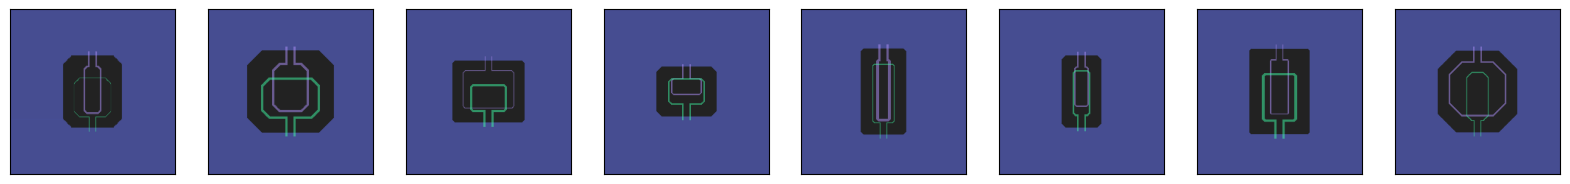

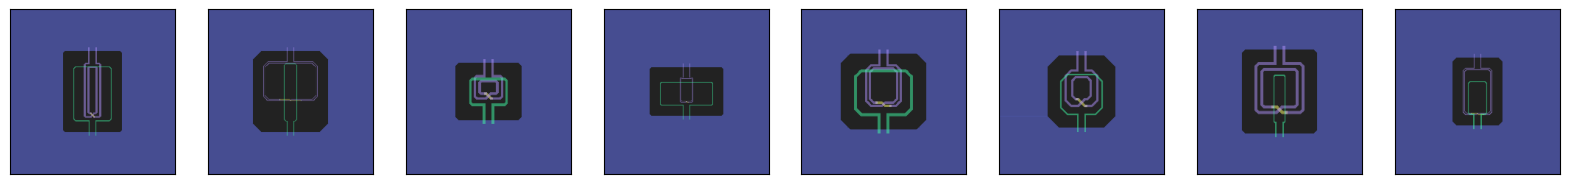

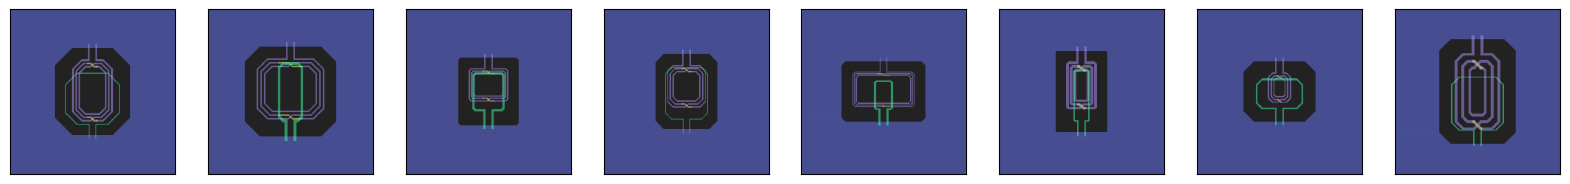

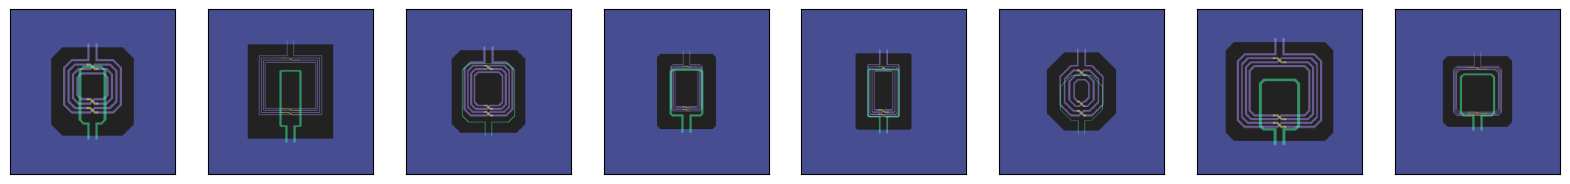

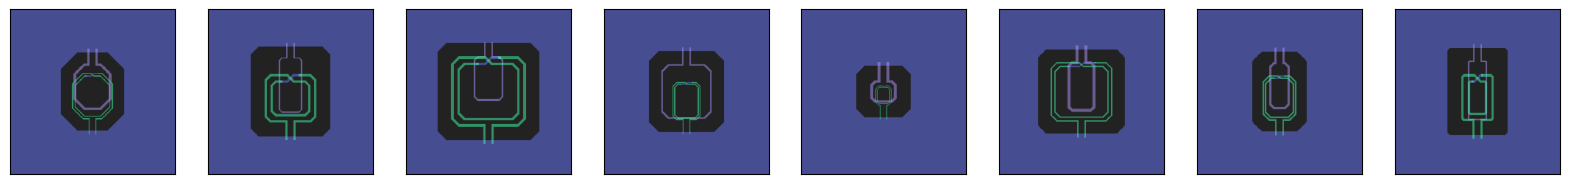

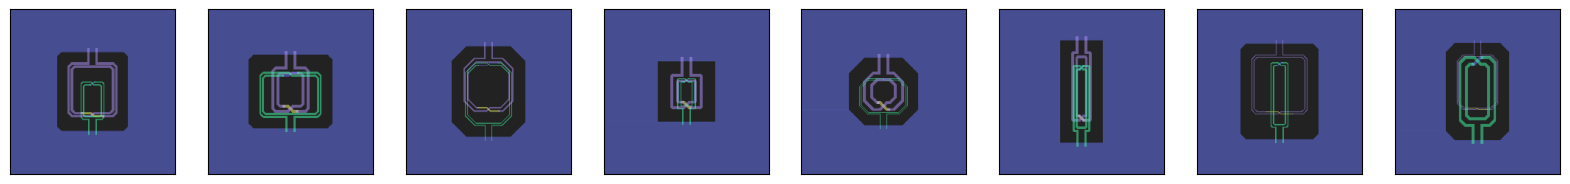

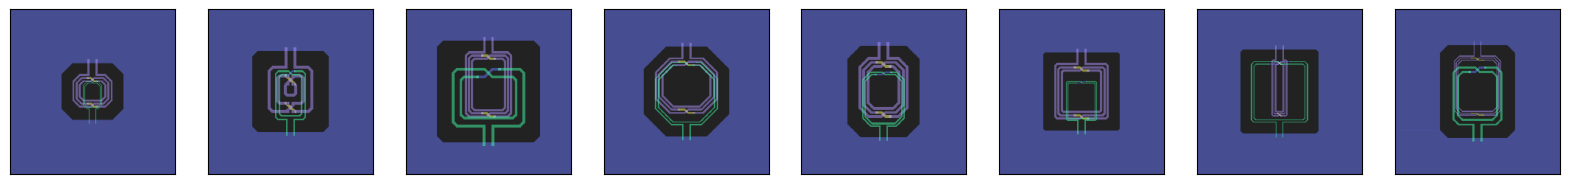

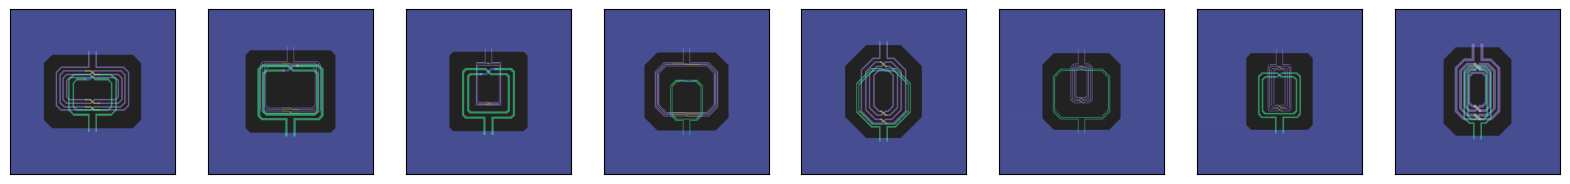

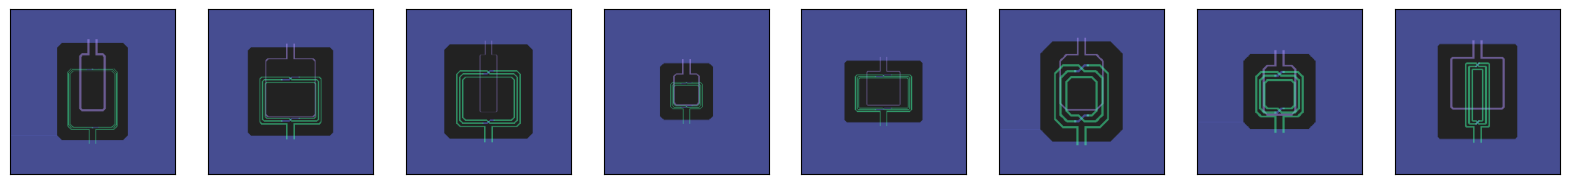

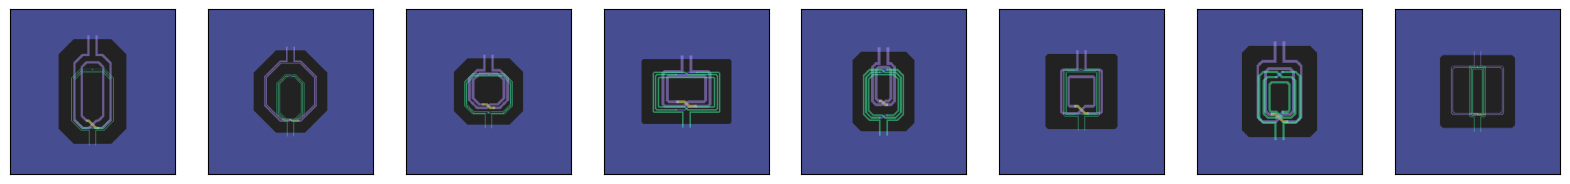

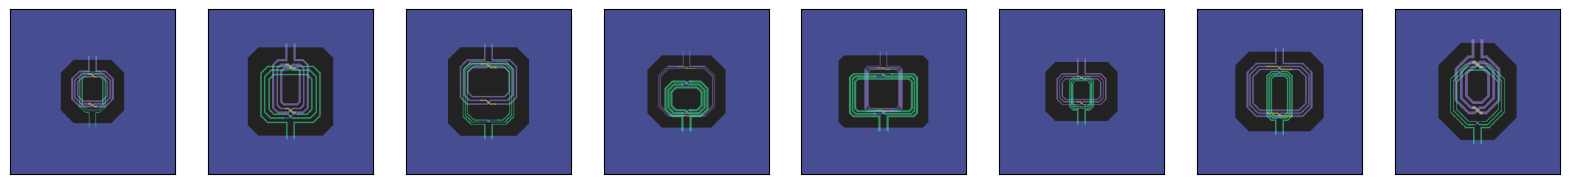

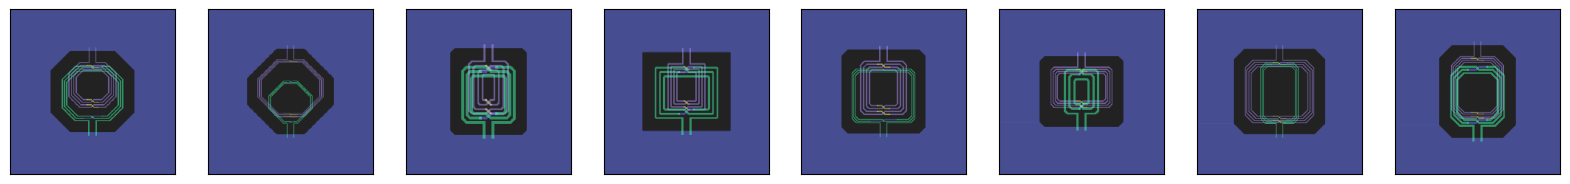

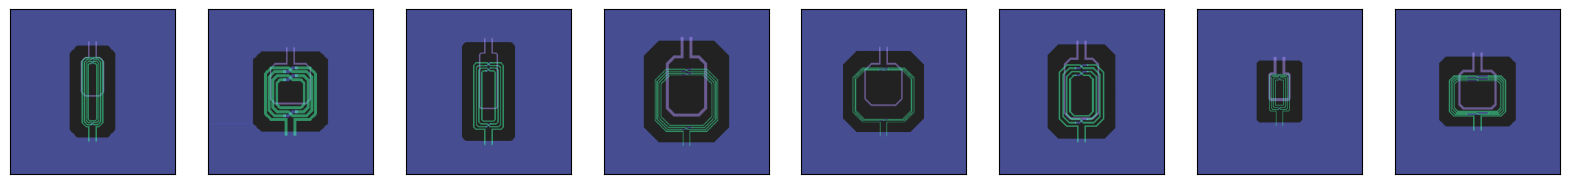

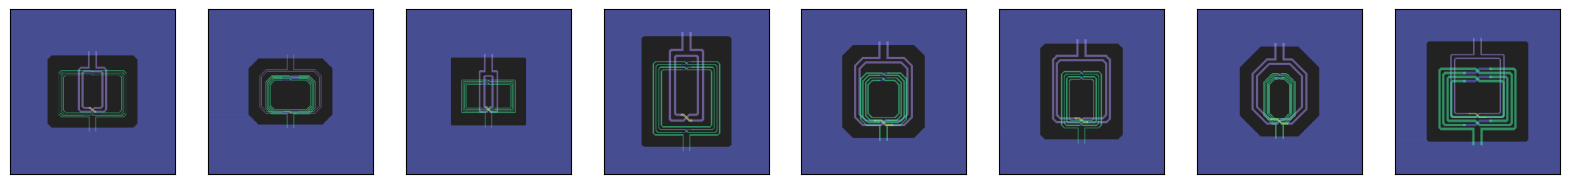

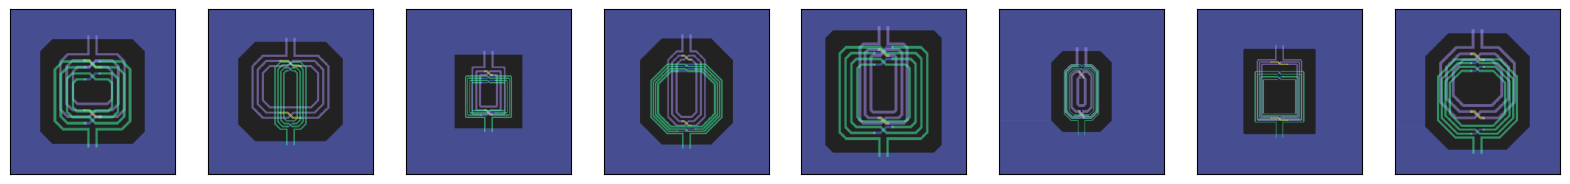

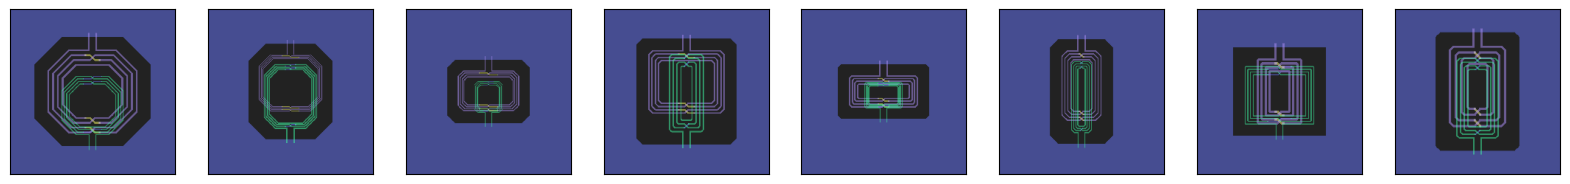

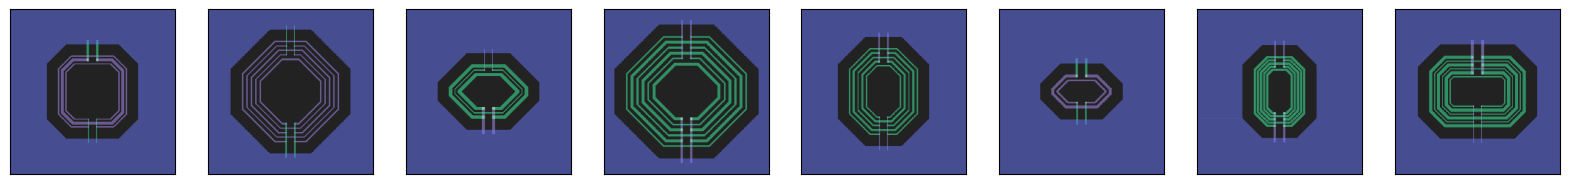

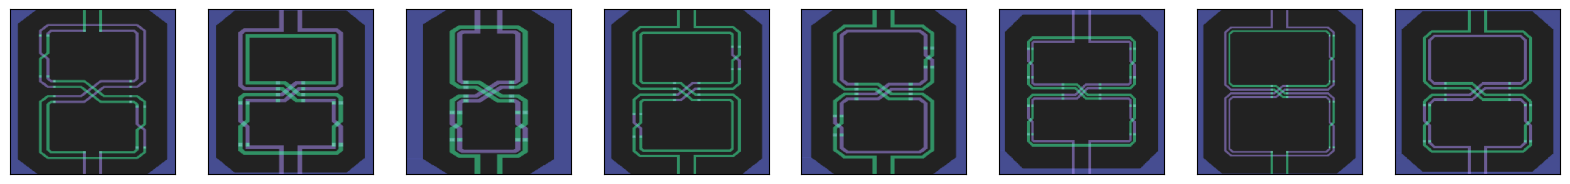

In [6]:
#load data
#geometrical parameters stored in log.txt
#order of geopara (radiusA,radiusB,turnsA,turnsB,openA,openB,outA,outB,extA,extB,ratio,outbound)
geoparas = []
images11 = []
labels11 = []
srf_list = []
#MxN
for i in range(4):
    for j in range(4):
        path = "/rdf/shared/design_automation/Data_EMX/XFMR_2503_"+str(i+1)+"x"+str(j+1)+"/"
        load_from_path_MxN(path)
#Parallel
path = "/rdf/shared/design_automation/Data_EMX/XFMRParallel_2504/"
load_from_path_parallel(path)
#8shaped
path = "/rdf/shared/design_automation/Data_EMX/XFMR8Shaped1x2_2504/"
load_from_path_8shaped(path)

In [7]:
#normalize geometrical inputs
geoparas_temp = np.array(geoparas)
geoparas = np.zeros(np.shape(geoparas_temp))
for i in range(len(geoparas)):
    for j in range(14):
        geoparas[i,j]= (geoparas_temp[i,j]-np.mean(geoparas_temp[:,j]))/np.std(geoparas_temp[:,j])

#construct the datasets
class item:
  def __init__(self, image,geopara,label,srf):
    self.image = image
    self.geopara = geopara
    self.label = label
    self.srf = srf
data = []
for i in range(len(images11)):
    data.append(item(images11[i],geoparas[i],labels11[i],srf_list[i]))

np.random.shuffle(data)

#define the split length for training, validation and test datasets
length = len(images11)
split1 = int(0.8*length)
split2 = int(0.9*length)
data_train = data[0:split1]
data_valid = data[split1:split2]
data_test = data[split2:]


#Separate the training, validation and test datasets 
train_images = []
train_labels = []
train_geoparas = []
train_srf = []
valid_images = []
valid_labels = []
valid_geoparas = []
valid_srf = []
test_images = []
test_labels = []
test_geoparas = []
test_srf = []

#The targeted frequency span up to fmax, with 1GHz step
s_max = np.zeros((fmax,12))
s_min = np.zeros((fmax,12))
srange = np.zeros((fmax,12))


for i in range(len(data_train)):
    train_images.append(data_train[i].image)
    train_geoparas.append(data_train[i].geopara)
    train_labels.append(data_train[i].label)
    train_srf.append(data_train[i].srf)
x_train_img = np.array(train_images) / 255
x_train_srf = np.array(train_srf)
x_train_geopara = np.array(train_geoparas)
y_train_encoded = np.array(train_labels)[:,1:fmax+1,:]


for i in range(len(data_valid)):
    valid_images.append(data_valid[i].image)
    valid_geoparas.append(data_valid[i].geopara)
    valid_labels.append(data_valid[i].label)
    valid_srf.append(data_valid[i].srf)
x_valid_img = np.array(valid_images) / 255
x_valid_srf = np.array(valid_srf)
x_valid_geopara = np.array(valid_geoparas)
y_valid_encoded = np.array(valid_labels)[:,1:fmax+1,:]


for i in range(len(data_test)):
    test_images.append(data_test[i].image)
    test_geoparas.append(data_test[i].geopara)
    test_labels.append(data_test[i].label)
    test_srf.append(data_test[i].srf)
x_test_img = np.array(test_images) / 255
x_test_srf = np.array(test_srf)
x_test_geopara = np.array(test_geoparas)
y_test_encoded = np.array(test_labels)[:,1:fmax+1,:]

#normalize the s-parameters for each frequency point
for z in range(fmax):
    for i in range(12):
        s_max[z,i] = max(max(y_train_encoded[:,z,i]),max(y_valid_encoded[:,z,i]),max(y_test_encoded[:,z,i]))
        s_min[z,i] = min(min(y_train_encoded[:,z,i]),min(y_valid_encoded[:,z,i]),min(y_test_encoded[:,z,i]))
        srange[z,i] = s_max[z,i]-s_min[z,i]
    
    for i in range(12):
        y_train_encoded[:,z,i] = 2*(y_train_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

    for i in range(12):
        y_valid_encoded[:,z,i] = 2*(y_valid_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1
    
    for i in range(12):
        y_test_encoded[:,z,i] = 2*(y_test_encoded[:,z,i]-s_min[z,i])/srange[z,i]-1

In [24]:
class SwinWithHead(nn.Module):
    def __init__(self,
                 backbone_name: str,
                 fmax: int,
                 n_targets: int = 12,
                 ckpt_path: str = None,
                 freeze_backbone: bool = True,
                 in_chans: int = 3,
                 img_size: int = 224,
                 rank: int = 32):
        super().__init__()
        self.fmax = int(fmax)
        self.n_targets = int(n_targets)
        self.rank = int(rank)

        # Backbone (features only)
        self.backbone = timm.create_model(
            backbone_name, pretrained=False, num_classes=0,
            in_chans=in_chans, img_size=img_size, global_pool=''
        )
        sd = None
        if ckpt_path is not None:
            sd = torch.load(ckpt_path, map_location="cpu")
            self.backbone.load_state_dict(sd, strict=False)

        if freeze_backbone:
            for p in self.backbone.parameters():
                p.requires_grad_(False)

        # Infer feature dims (supports (B,C,H,W) / (B,N,C) / (B,C))
        with torch.no_grad():
            dummy = torch.zeros(1, in_chans, img_size, img_size)
            feats = self.backbone.forward_features(dummy)
            if feats.dim() == 4:
                self._feat_mode = 'bchw'; feat_dim = feats.shape[1]
            elif feats.dim() == 3:
                self._feat_mode = 'tokens'; feat_dim = feats.shape[-1]
            elif feats.dim() == 2:
                self._feat_mode = 'vec'; feat_dim = feats.shape[-1]
            else:
                raise RuntimeError(f"Unexpected features shape: {tuple(feats.shape)}")

        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # for (B,C,H,W)

        # MLP trunk (same width/depth)
        self.head = nn.Sequential(
            nn.Linear(feat_dim, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,512),
            nn.ReLU(inplace=True),
            nn.Linear(512,512),
            nn.ReLU(inplace=True)
        )
        self.out = nn.Linear(512, fmax * 12)
        self.reshape = lambda x: x.view(-1, fmax, 12)
        
        # Optional: initialize bases to smooth functions (tiny scale)
        # with torch.no_grad():
        #     t = torch.linspace(0, 1, steps=self.fmax)
        #     for r in range(self.rank):
        #         self.bases[r].copy_(torch.cos(r * torch.pi * t) * 0.02)

    def forward(self, x):
        f = self.backbone.forward_features(x)
        if self._feat_mode == 'bchw':      # (B,C,H,W) -> (B,C)
            f = self.pool(f).flatten(1)
        elif self._feat_mode == 'tokens':  # (B,N,C) -> (B,C)
            f = f.mean(dim=1)
        # else: (B,C) already

        f = self.head(f)                                   # (B, 512)
        out = torch.tanh(self.out(f))
        out = self.reshape(out)
        # Optional lightweight guard (remove if you prefer)
        # assert y.shape[1] == self.fmax and y.shape[2] == self.n_targets, y.shape

        return out

In [25]:
device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")

In [26]:
def custom_loss(y_true, y_pred):
    # Compute squared error
    Lf = torch.sqrt(torch.mean((y_true - y_pred) ** 2, dim=1))  # sqrt(mean(square_error), dim=1
    
    return torch.mean(Lf)  # Mean across all samples

GPU memory before: 0.00GB
Epoch [1/60]  Train Loss: 0.3463, Train MAE: 0.2936  Val Loss: 0.3449, Val MAE: 0.2922
Epoch [20/60]  Train Loss: 0.3451, Train MAE: 0.2924  Val Loss: 0.3449, Val MAE: 0.2923
Epoch [40/60]  Train Loss: 0.3450, Train MAE: 0.2923  Val Loss: 0.3449, Val MAE: 0.2920
Epoch [60/60]  Train Loss: 0.3450, Train MAE: 0.2923  Val Loss: 0.3449, Val MAE: 0.2922

Total training time: 21.27 minutes


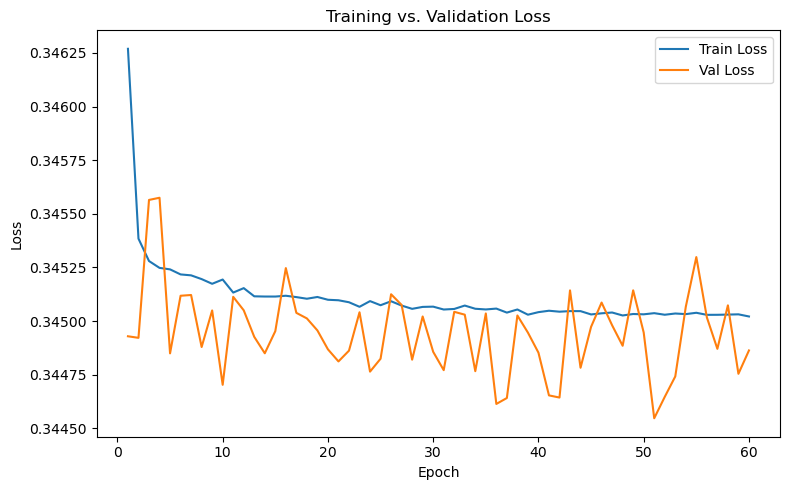

GPU memory after: 0.00GB


In [28]:
# -------- Validation (GPU-friendly; no per-batch host sync) --------
def validate_one_epoch(model, val_loader, loss_function):
    model.eval()
    loss_acc = torch.zeros((), device=device)
    mae_acc  = torch.zeros((), device=device)

    with torch.no_grad():
        for inp0, inp1, y_true in val_loader:
            inp0, inp1, y_true = [x.to(device, non_blocking=True) for x in (inp0, inp1, y_true)]
            y_pred = model(inp0)
            loss   = loss_function(y_true, y_pred)
            mae_val = torch.mean(torch.abs(y_true - y_pred))
            loss_acc += loss
            mae_acc  += mae_val

    avg_loss = (loss_acc / len(val_loader)).item()
    avg_mae  = (mae_acc  / len(val_loader)).item()
    return avg_loss, avg_mae

# -------- Hyperparams (same as before) --------
learning_rate = 1e-3
epochs        = 60

# -------- Initialize model (frozen backbone) --------
nband   = int(1)
overlap = int(1)
fband   = int(fmax * overlap / nband)
bandslice = int(fband / overlap)

# model = SwinWithHead(
#     backbone_name="swin_tiny_patch4_window7_224",
#     fmax=fband,                 # match label's 1st inner dim
#     n_targets=12,               # match label's last dim
#     ckpt_path="/home/ch106/Desktop/multimodal/schem_encoder/weights/self_supervised/0.pth",
#     freeze_backbone=True
# ).to(device)
model = SwinWithHead(
    backbone_name="swin_tiny_patch4_window7_224",
    fmax=fband,                  # must equal labels.shape[1]
    n_targets=12,                # must equal labels.shape[2]
    ckpt_path="/home/ch106/Desktop/multimodal/schem_encoder/weights/self_supervised/0.pth",
    freeze_backbone=True,
    in_chans=3,                  # set to 1 if grayscale images
    img_size=224,                # match your training transforms
    rank=32                      # kept for API compat; unused internally
).to(device)

optimizer = optim.AdamW(model.parameters(), lr=learning_rate)

def lr_lambda(epoch):
    return 0.95 ** (epoch / 100)  # same schedule behavior
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# -------- Loss function (unchanged semantics) --------
loss_function = custom_loss

# (Optional metric if you use it elsewhere)
def mae(y_true, y_pred):
    return torch.mean(torch.abs(y_true - y_pred))

# -------- Build datasets/loaders (CPU tensors, pinned, workers) --------
torch.cuda.empty_cache()
batch_size = 32
xx = 0

# CPU tensors (do NOT move whole tensors to GPU; we use async per-batch copies)
yout = torch.from_numpy(y_train_encoded[:, (xx * fband):(xx + 1) * fband]).to(torch.float32)
x1   = torch.from_numpy(x_train_img).permute(0, 3, 1, 2).contiguous()
x2   = torch.from_numpy(x_train_geopara).to(torch.float32)

dataset   = torch.utils.data.TensorDataset(x1, x2, yout)
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=4,              # adjust per machine (e.g., 4–8)
    persistent_workers=True,
    prefetch_factor=2,
)

yout_valid = torch.from_numpy(y_valid_encoded[:, (xx * fband):(xx + 1) * fband]).to(torch.float32)
x1_valid   = torch.from_numpy(x_valid_img).permute(0, 3, 1, 2).contiguous()
x2_valid   = torch.from_numpy(x_valid_geopara).to(torch.float32)

val_dataset    = torch.utils.data.TensorDataset(x1_valid, x2_valid, yout_valid)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
    pin_memory=True,
    num_workers=4,
    persistent_workers=True,
    prefetch_factor=2,
)

# -------- Training loop (GPU-first; async transfers; same logging cadence) --------
def train_model(model, optimizer, scheduler, loss_function,
                num_epochs, train_loader, val_loader=None):
    start_time = time.time()
    train_losses, val_losses = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        loss_acc = torch.zeros((), device=device)
        mae_acc  = torch.zeros((), device=device)

        for inp0, inp1, y_true in train_loader:
            inp0, inp1, y_true = [x.to(device, non_blocking=True) for x in (inp0, inp1, y_true)]
            optimizer.zero_grad(set_to_none=True)
            y_pred = model(inp0)
            loss   = loss_function(y_true, y_pred)
            loss.backward()
            optimizer.step()

            loss_acc += loss
            mae_acc  += torch.mean(torch.abs(y_true - y_pred))

        scheduler.step()

        avg_train_loss = (loss_acc / len(train_loader)).item()
        avg_train_mae  = (mae_acc  / len(train_loader)).item()
        train_losses.append(avg_train_loss)

        # ---- VALIDATION ----
        if val_loader is not None:
            val_loss, val_mae = validate_one_epoch(model, val_loader, loss_function)
            val_losses.append(val_loss)
        else:
            val_loss = val_mae = None

        # ---- LOGGING (every 20 epochs, and first/last) ----
        if epoch % 20 == 0 or epoch == 1 or epoch == num_epochs:
            msg = (f"Epoch [{epoch}/{num_epochs}]  "
                   f"Train Loss: {avg_train_loss:.4f}, Train MAE: {avg_train_mae:.4f}")
            if val_loader is not None:
                msg += f"  Val Loss: {val_loss:.4f}, Val MAE: {val_mae:.4f}"
            print(msg)

    if str(device).startswith("cuda"):
        torch.cuda.synchronize()
    total_time = time.time() - start_time
    print(f"\nTotal training time: {total_time/60:.2f} minutes")

    # Plot (same functionality)
    ep_axis = range(1, num_epochs + 1)
    plt.figure(figsize=(8,5))
    plt.plot(ep_axis, train_losses, label="Train Loss")
    if val_loader is not None:
        plt.plot(ep_axis, val_losses, label="Val Loss")
    plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training vs. Validation Loss")
    plt.legend(); plt.tight_layout(); plt.show()

# -------- Kick off training --------
print(f"GPU memory before: {torch.cuda.memory_allocated()/1024**3:.2f}GB")
train_model(model, optimizer, scheduler, loss_function, epochs, dataloader, val_dataloader)
print(f"GPU memory after: {torch.cuda.memory_allocated()/1024**3:.2f}GB")

# -------- Save weights (unchanged) --------
torch.save(model.state_dict(), './weights/all/Swin/'+str(xx) + '.pth')

In [29]:
# Frequency forward loop
def forward_loop():
    for ff in range(nband - overlap):
        xx = ff + 1
    #print(f"Processing dataset for frequency band {xx}")

    # Load model weights
        model.load_state_dict(torch.load('./weights/all/Swin/'+str(xx) + '.pth'))  # Load saved weights
        model.to(device)  # Ensure the model is on the correct device

    # Prepare new dataset for this iteration
        yout = torch.from_numpy(y_train_encoded[:, (xx * bandslice):(xx + overlap) * bandslice])
        yout = yout.type(torch.float32).to(device)  # Move data to the device
        dataset = torch.utils.data.TensorDataset(x1, x2, yout)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Reinitialize optimizer and scheduler with the updated model parameters
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)

    # Train the model on the new dataset
        train_model(model, optimizer, scheduler, loss_function, epochs, dataloader)

    # Save the updated model weights
        torch.save(model.state_dict(), './weights/all/Swin/'+str(xx) + '.pth')


# Frequency backward loop
def backward_loop():
    for ff in range(nband - overlap):
        xx = nband - ff - 1 - overlap
        #print(f"Processing dataset for frequency band {xx}")

    # Load model weights
        model.load_state_dict(torch.load('./weights/all/Swin/'+str(xx) + '.pth'))  # Load saved weights
        model.to(device)  # Ensure the model is on the correct device

    # Prepare new dataset for this iteration
        yout = torch.from_numpy(y_train_encoded[:, (xx * bandslice):(xx + overlap) * bandslice])
        yout = yout.type(torch.float32).to(device)  # Move data to the device
        dataset = torch.utils.data.TensorDataset(x1, x2, yout)
        dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Reinitialize optimizer and scheduler with the updated model parameters
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.995)

    # Train the model on the new dataset
        train_model(model, optimizer, scheduler, loss_function, epochs, dataloader)

    # Save the updated model weights
        torch.save(model.state_dict(), './weights/all/Swin/'+str(xx) + '.pth')

def prediction(ax):
    test_prediction_raw = np.zeros((len(x_test_img),fmax*overlap,12))
    test_prediction = np.zeros((len(x_test_img),fmax,12))
    xtest = torch.from_numpy(x_test_img)
    xtest = xtest.type(torch.float32)
    xtest = xtest.permute(0, 3, 1, 2)
    for xx in range(nband+1-overlap):
        model_cpu = SwinWithHead(
            backbone_name="swin_tiny_patch4_window7_224",
            fmax=fband,                 # match label's 1st inner dim
            n_targets=12,               # match label's last dim
            ckpt_path="/home/ch106/Desktop/multimodal/schem_encoder/weights/self_supervised/0.pth",
            freeze_backbone=True
        )
        model_cpu.load_state_dict(torch.load('./weights/all/Swin/'+str(xx) + '.pth'))
        test_prediction_raw[:,fband*xx:fband*(xx+1),:] = model_cpu(xtest).detach().numpy()
        mae_all = np.zeros((fmax,12))
    mae_mean = np.zeros(fmax)
    for xx in range(nband):
        print(xx)
        if xx<overlap:
            for yy in range(1+xx):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx-yy)+yy*bandslice:fband*(xx-yy)+(yy+1)*bandslice,:])
            test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(1+xx)
        elif(nband-xx<overlap):
            for yy in range(2+xx-nband):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx+1-overlap-yy)+(overlap-1-yy)*bandslice:fband*(xx+1-overlap-yy)+(overlap-yy)*bandslice,:])
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(2+xx-nband)
        else:
            for yy in range(overlap):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx-yy)+yy*bandslice:fband*(xx-yy)+(yy+1)*bandslice,:])
            test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(overlap)
    for z in range(fmax):
        for i in range(12):
            mae_all[z][i] = np.mean(abs(test_prediction[:,z,i]-y_test_encoded[:,z,i]))*0.5*srange[z,i]
        mae_mean[z] = np.mean(mae_all[z][:])
    ax.plot(range(fmax),mae_mean)
    #ax.plt.xlabel('Frequency/GHz')
    #ax.plt.ylabel('Average S-parameter mae')
    print(np.mean(mae_mean))
    print(R_squared(torch.from_numpy(y_test_encoded),torch.from_numpy(test_prediction)))
    return np.mean(mae_mean)

def prediction_srf(ax):
    test_prediction_raw = np.zeros((len(x_test_img),fmax*overlap,12))
    test_prediction = np.zeros((len(x_test_img),fmax,12))
    xtest = torch.from_numpy(x_test_img)
    xtest = xtest.type(torch.float32)
    xtest = xtest.permute(0, 3, 1, 2)
    for xx in range(nband+1-overlap):
        model_cpu = SwinWithHead(
            backbone_name="swin_tiny_patch4_window7_224",
            fmax=fband,                 # match label's 1st inner dim
            n_targets=12,               # match label's last dim
            ckpt_path="/home/ch106/Desktop/multimodal/schem_encoder/weights/self_supervised/0.pth",
            freeze_backbone=True
        )
        model_cpu.load_state_dict(torch.load('./weights/all/Swin/'+str(xx) + '.pth'))
        test_prediction_raw[:,fband*xx:fband*(xx+1),:] = model_cpu(xtest).detach().numpy()
        mae_all = np.zeros((fmax,12))
    mae_mean = np.zeros(fmax)
    for xx in range(nband):
        print(xx)
        if xx<overlap:
            for yy in range(1+xx):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx-yy)+yy*bandslice:fband*(xx-yy)+(yy+1)*bandslice,:])
            test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(1+xx)
        elif(nband-xx<overlap):
            for yy in range(2+xx-nband):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx+1-overlap-yy)+(overlap-1-yy)*bandslice:fband*(xx+1-overlap-yy)+(overlap-yy)*bandslice,:])
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(2+xx-nband)
        else:
            for yy in range(overlap):
                test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = (test_prediction[:,bandslice*xx:bandslice*(xx+1),:]
                                                                            +test_prediction_raw[:,fband*(xx-yy)+yy*bandslice:fband*(xx-yy)+(yy+1)*bandslice,:])
            test_prediction[:,bandslice*xx:bandslice*(xx+1),:] = test_prediction[:,bandslice*xx:bandslice*(xx+1),:]/(overlap)
    n_srf = 100
    srf_mae_all = np.zeros((n_srf,12))
    srf_mae = np.zeros(n_srf)
    for z in range(n_srf):
        for sample in range(len(xtest)):
            freq_temp = int(min(fmax-1,z*test_srf[sample]*4/n_srf))            
            for i in range(12):
                srf_mae_all[z][i] += (abs(test_prediction[sample,freq_temp,i]-y_test_encoded[sample,freq_temp,i]))*0.5*srange[freq_temp,i]
        srf_mae_all[z] = srf_mae_all[z]/len(xtest)
        srf_mae[z] = np.mean(srf_mae_all[z][:])
    ax.plot((2/n_srf)*np.ones(n_srf)*range(n_srf),srf_mae)
    #ax.plt.xlabel('Frequency Normalized to SRF')
    #plt.ylabel('Average S-parameter mae')
    print(np.mean(srf_mae))
    print(R_squared(torch.from_numpy(y_test_encoded),torch.from_numpy(test_prediction)))
    return np.mean(srf_mae)
    
def R_squared(y, y_pred):
    # Residual sum of squares
    residual = torch.sum((y - y_pred) ** 2)
    
    # Total sum of squares
    total = torch.sum((y - torch.mean(y)) ** 2)
    
    # Compute R-squared
    r2 = 1.0 - (residual / total)
    return r2

0
0
0.20522695205367547
tensor(0.1742, dtype=torch.float64)
0
0.18556575823096477
tensor(0.1742, dtype=torch.float64)
1
0
0.20522695205367547
tensor(0.1742, dtype=torch.float64)
0
0.18556575823096477
tensor(0.1742, dtype=torch.float64)
2
0
0.20522695205367547
tensor(0.1742, dtype=torch.float64)
0
0.18556575823096477
tensor(0.1742, dtype=torch.float64)
3
0
0.20522695205367547
tensor(0.1742, dtype=torch.float64)
0
0.18556575823096477
tensor(0.1742, dtype=torch.float64)
4
0
0.20522695205367547
tensor(0.1742, dtype=torch.float64)
0
0.18556575823096477
tensor(0.1742, dtype=torch.float64)


Text(0, 0.5, 'Average S-parameter mae')

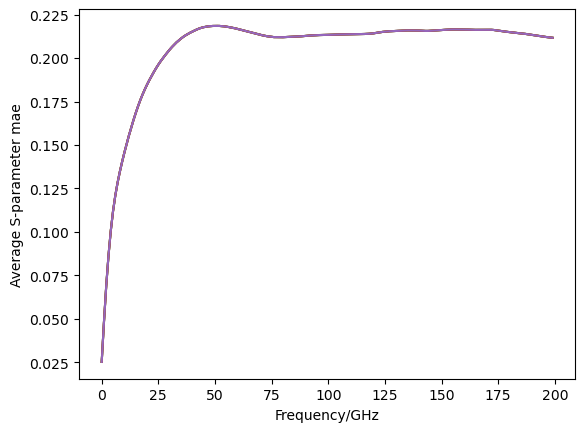

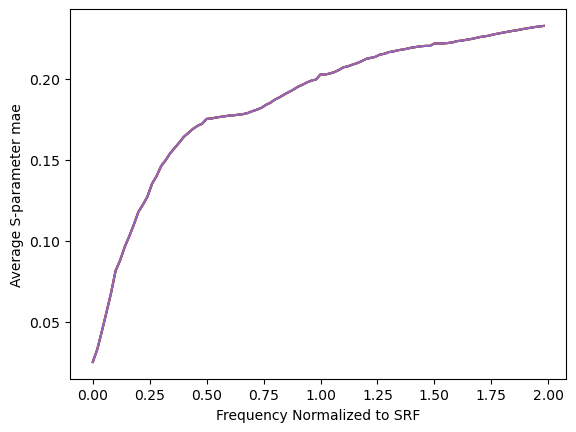

In [30]:
epochs = 200
iteration = 5
fig1, ax1 = plt.subplots()
fig2, ax2 = plt.subplots()
mae_trend = np.zeros(iteration)
for ii in range(iteration):
    epochs = epochs
    forward_loop()
    backward_loop()
    print(ii)
    mae_trend[ii]=prediction(ax1)
    prediction_srf(ax2)
ax1.set_xlabel('Frequency/GHz')
ax1.set_ylabel('Average S-parameter mae')
ax2.set_xlabel('Frequency Normalized to SRF')
ax2.set_ylabel('Average S-parameter mae')

In [34]:
with torch.no_grad():
    print(tuple(model.backbone.forward_features().shape))

TypeError: SwinTransformer.forward_features() missing 1 required positional argument: 'x'

In [31]:
summary(model, input_size=(1,3,224,224))

NameError: name 'summary' is not defined